# Training a new bird species prediction model

In this walkthrough, I will retrain the bird detection model to add new species from drone monitoring Poland. These data come from Dominik Marchowski studying waterfowl. The folder structure is a set of annotations in a shapefile alongside an image. Each bird is labeled with a dot and a species ID. We need to convert these dots into bounding boxes.

In [1]:
!pip install deepforest gdown --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 145.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from deepforest import visualize
from deepforest import main
from matplotlib import pyplot as plt
import glob
import os
import cv2
from shapely.geometry import Point, box
from google.colab import drive

# Download data
drive.mount("/content/drive/")

!cp -r "/content/drive/MyDrive/Bird Detector Walkthrough/Poland/" /content/

Mounted at /content/drive/


/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


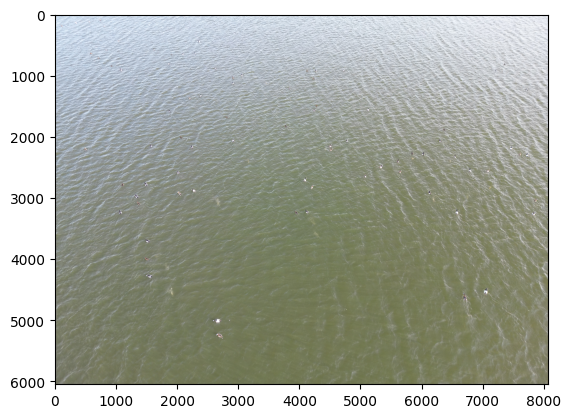

In [4]:
image = rio.open("/content/Poland/Ayth_22.JPG").read()
annotations = gpd.read_file("/content/Poland/Ayth_22.shp")
plt.imshow(np.rollaxis(image, 0, 3))

In [5]:
# Load all annotations, label them with the image_path and turn into bounding boxes using a fixed pixel size
shapefiles = glob.glob("/content/Poland/*.shp")
point_annotations = []
for shapefile in shapefiles:
    shp = gpd.read_file(shapefile)
    #Shapefile and image have same name, but different extension
    shp["image_path"] = "{}.JPG".format(os.path.splitext(os.path.basename(shapefile))[0])
    point_annotations.append(shp)

point_annotations = pd.concat(point_annotations)
gdf = gpd.GeoDataFrame(point_annotations, geometry="geometry")
gdf["geometry"] = [box(left, bottom, right, top) for left, bottom, right, top in gdf.geometry.buffer(75).bounds.values]
gdf["label"] = gdf["species"]
gdf[["xmin","ymin","xmax","ymax"]] = gdf.geometry.bounds
gdf

<ipython-input-5-5398a01892df>:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = [box(left, bottom, right, top) for left, bottom, right, top in gdf.geometry.buffer(75).bounds.values]


,age,sex,species,geometry,image_path,id,genus,date,label,xmin,ymin,xmax,ymax
0,ad,male,Aythya marila,"POLYGON ((2730.75534 -5087.39595, 2730.75534 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2580.755337,-5087.395951,2730.755337,-4937.395951
1,?,female,Aythya marila,"POLYGON ((2768.74086 -5328.94491, 2768.74086 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2618.740859,-5328.944908,2768.740859,-5178.944908
2,ad,male,Aythya marila,"POLYGON ((2342.13423 -2960.20675, 2342.13423 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2192.134233,-2960.206748,2342.134233,-2810.206748
3,?,female,Aythya marila,"POLYGON ((2107.40319 -3005.01018, 2107.40319 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,1957.403190,-3005.010184,2107.403190,-2855.010184
4,ad,male,Aythya marila,"POLYGON ((2989.83607 -2141.08307, 2989.83607 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2839.836074,-2141.083067,2989.836074,-1991.083067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,ad,male,Aythya marila,"POLYGON ((3425.22331 -2554.86229, 3425.22331 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,3275.223305,-2554.862288,3425.223305,-2404.862288
22,?,female,Aythya marila,"POLYGON ((3910.10975 -2984.97076, 3910.10975 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,3760.109746,-2984.970763,3910.109746,-2834.970763
23,?,female,Aythya marila,"POLYGON ((3917.21059 -2700.93686, 3917.21059 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,3767.210593,-2700.936864,3917.210593,-2550.936864
24,?,female,Aythya marila,"POLYGON ((4653.66992 -2988.01398, 4653.66992 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,4503.669915,-2988.013983,4653.669915,-2838.013983


### Why are the y coordinates negative?

One of the challenges of working with image data is that we need to define 0,0 to express the pixel locations when drone images have not been projected coordinate systems. Unfortunately, every program decides what 0,0 is. These data were annotated in QGIS, which uses 0,0 in the top left corner. If you look the image above, you will see that rasterio has decided 0,0 is bottom left. We can match the image coordinate systems by interpreting as -420 as 420 pixels from the top. 

/usr/local/lib/python3.9/dist-packages/deepforest/visualize.py:115: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


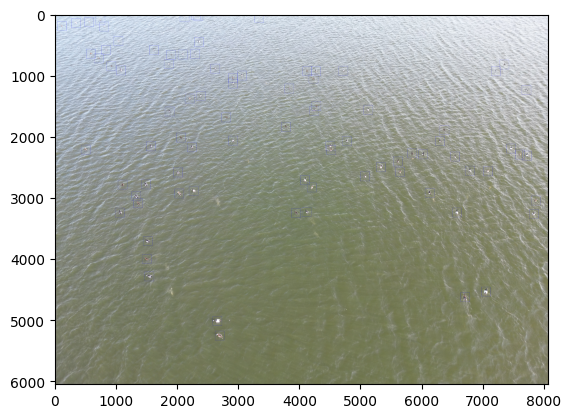

In [6]:
flipped_ymax = image.shape[0] - gdf.ymin 
flipped_ymin = image.shape[0] - gdf.ymax 
gdf["ymin"] = flipped_ymin
gdf["ymax"] = flipped_ymax
fig = visualize.plot_predictions(image.copy(), df=gdf[gdf.image_path=="Ayth_22.JPG"], color=(0,0,255))
plt.imshow(fig)

In [7]:
gdf

,age,sex,species,geometry,image_path,id,genus,date,label,xmin,ymin,xmax,ymax
0,ad,male,Aythya marila,"POLYGON ((2730.75534 -5087.39595, 2730.75534 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2580.755337,4940.395951,2730.755337,5090.395951
1,?,female,Aythya marila,"POLYGON ((2768.74086 -5328.94491, 2768.74086 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2618.740859,5181.944908,2768.740859,5331.944908
2,ad,male,Aythya marila,"POLYGON ((2342.13423 -2960.20675, 2342.13423 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2192.134233,2813.206748,2342.134233,2963.206748
3,?,female,Aythya marila,"POLYGON ((2107.40319 -3005.01018, 2107.40319 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,1957.403190,2858.010184,2107.403190,3008.010184
4,ad,male,Aythya marila,"POLYGON ((2989.83607 -2141.08307, 2989.83607 -...",Ayth_22.JPG,NaN,NaN,NaN,Aythya marila,2839.836074,1994.083067,2989.836074,2144.083067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,ad,male,Aythya marila,"POLYGON ((3425.22331 -2554.86229, 3425.22331 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,3275.223305,2407.862288,3425.223305,2557.862288
22,?,female,Aythya marila,"POLYGON ((3910.10975 -2984.97076, 3910.10975 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,3760.109746,2837.970763,3910.109746,2987.970763
23,?,female,Aythya marila,"POLYGON ((3917.21059 -2700.93686, 3917.21059 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,3767.210593,2553.936864,3917.210593,2703.936864
24,?,female,Aythya marila,"POLYGON ((4653.66992 -2988.01398, 4653.66992 -...",Ayth_4.JPG,NaN,NaN,NaN,Aythya marila,4503.669915,2841.013983,4653.669915,2991.013983


## Evaluation split

We need to hold back several images to assess model performance. It is best practice to do this at the image level, rather than having training and evaluation annotations from the same image.

In [8]:
gdf = gdf[gdf.species.isin(["Aythya marila","Aythya fuligula","Aythya ferina","Bucephala clangula"])]
labels = ["Aythya marila","Aythya fuligula","Aythya ferina","Bucephala clangula"]
label_dict  = {value:key for key,value in enumerate(labels)}

#Make sure no annotations fall off the edge by small margins
def check_shape(df, root_dir):
    """Make sure no annotations fall off edges of crops
    Args:
        df: a pandas dataframe with image_path, xmax, ymax
    """
    updated_data = []
    for name, group in df.groupby("image_path"):
        img = cv2.imread("{}/{}".format(root_dir, name))
        height = img.shape[0]
        width = img.shape[1]
        group["xmax"] = group.xmax.apply(lambda x: x if x < width else width)
        group["ymax"] = group.ymax.apply(lambda y: y if y < height else height)
        
        #Throw out annotations if they begin off edge
        group = group[~(group.xmin > width)]
        group = group[~(group.ymin > height)]
        group = group[group.xmin > 0]
        group = group[group.ymin > 0]
        updated_data.append(group)
        
    df = pd.concat(updated_data)    
    
    return df

gdf = check_shape(gdf, root_dir = "/content/Poland")

evaluation_images = gdf.image_path.unique()[0:5]
train_images = gdf.image_path.unique()[5:]
train =  gdf[gdf.image_path.isin(train_images)]
evaluation = gdf[gdf.image_path.isin(evaluation_images)]

# Lets look at the classes and do some cleaning
print(gdf.species.value_counts())
print(train.species.unique())
print(evaluation.species.unique())

train.to_csv("/content/Poland/train.csv")
evaluation.to_csv("/content/Poland/evaluation.csv")

Aythya marila         512
Aythya fuligula       266
Aythya ferina          28
Bucephala clangula     23
Name: species, dtype: int64
['Aythya marila' 'Bucephala clangula' 'Aythya fuligula' 'Aythya ferina']
['Aythya fuligula' 'Aythya ferina' 'Aythya marila' 'Bucephala clangula']


# Load bird detection model

We want to start from a well performing model that already can detect birds in this kind of imagery.

In [ ]:
m = main.deepforest(label_dict={"Bird":0})
m.use_bird_release()
m.create_trainer()
channels_last_format = np.rollaxis(image, 0,3)
existing_model_prediction = m.predict_tile("/content/Poland/Ayth_22.JPG",
                                           return_plot=True, patch_size=1500, color=(0,0,0), thickness=3)
plt.figure(figsize=(20,20))
plt.imshow(existing_model_prediction[:,:,::-1])

Reading config file: /usr/local/lib/python3.9/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 95.1MB/s]


No validation file provided. Turning off validation loop


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


bird.pt: 129MB [00:01, 76.2MB/s]                           


Model was downloaded and saved to /usr/local/lib/python3.9/dist-packages/deepforest/data/bird.pt
Loading pre-built model: https://github.com/weecology/BirdDetector/releases/tag/1.1
Setting default score threshold to 0.3
No validation file provided. Turning off validation loop


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Predicting: 0it [00:00, ?it/s]

We can see excellent initial results, but we only have a 'bird' class. We need to retrain this model (apologies for the dark boxes, look closely) for the species in this dataset. Following https://deepforest.readthedocs.io/en/latest/getting_started.html#training, we can format the model.

In [ ]:
label_dict

In [ ]:
m = main.deepforest(num_classes=len(label_dict), label_dict=label_dict)
deepforest_release_model = main.deepforest()
deepforest_release_model.use_bird_release()
m.model.backbone.load_state_dict(deepforest_release_model.model.backbone.state_dict())
m.model.head.regression_head.load_state_dict(deepforest_release_model.model.head.regression_head.state_dict())

m.config["train"]["csv_file"] = "/content/Poland/train.csv"
m.config["train"]["root_dir"] = "/content/Poland/"
m.config["train"]['epochs'] = 1
m.config["score_thresh"] = 0.2
m.config["batch_size"] = 1
m.config["workers"] = 0
m.config["preload_images"] = True

m.create_trainer(profiler="simple")
m.trainer.fit(m)

In [ ]:
m.config["batch_size"] = 1
m.config["score_threshold"] = 0.05
results = m.evaluate("/content/Poland/evaluation.csv",root_dir="/content/Poland/")

In [ ]:
results["results"].predicted_label.value_counts()

In [ ]:
m.config